<a href="https://colab.research.google.com/github/jakob-morales/machine-learning-from-scratch/blob/main/KMeans_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
#Load the iris dataset
iris = datasets.load_iris(as_frame = True)

#Separate feature and target variables
X = iris.data
y = iris.target

#Complete DataFrane
df = iris.data

#Change dummy variable to species name
df['Species'] = iris.target.map(dict(zip([0,1,2],iris.target_names)))

#Drop target variable
X = X.drop('Species', axis=1)

def mink_distance (array1, array2, p=2):
  """Computes the Minkowski distance, which allows the user to input 1 for Manhattan distance or 2 for Euclidean distance."""

  distance = sum(abs(ii-i)**p for i, ii in zip(array1, array2))**(1/p)
  return distance

def close_cluster (X, clusters):
  """Find the closest cluster to each data point in a df."""
  closest_cluster = []
  for i in X.to_numpy():
    cluster_compare = []
    #for each k, find the distance betwwen each data point and the randomly generated cluster
    for ii in clusters:
      cluster_compare.append(mink_distance(i,ii, p=2))
    #return the closest cluster to the data point  
    closest_cluster.append(pd.DataFrame(cluster_compare).nsmallest(1, columns=0).index.to_list())
  result = [x[0] for x in closest_cluster]
  return result

In [93]:
cluster_list = []
inertias = []
predictions = []

def kmeans (X, k_clusters, n_init = 10):
  """Creates k clusters."""
  #A number of iterations is chosen to find the lowest inertia.
  for x in range(1, n_init):
    #Three random points are selected to act as clusters.
    indices = np.random.choice(range(len(X)), size = k_clusters)
    clusters = np.array(X.iloc[indices])
    #The closest centroid to each respective point in X is found.
    X['cluster'] = close_cluster(X, clusters)
    #The average is found for each cluster. This new average becomes the new cluster centroid.
    new_cluster = X.groupby('cluster').mean().to_numpy()
    #The closest centroid to each respective point in X is found again. 
    #This process repeats until repeating the process does not change cluster assignments.
    while np.mean(X['cluster'] == close_cluster(X, new_cluster)) != 1:
      X['cluster'] = close_cluster(X, new_cluster)
      new_cluster = X.groupby('cluster').mean().to_numpy()

    #Measure inertia.
    variances = []
    for i, x in enumerate(new_cluster):
      sq_differences = []
      for ii, y in enumerate(X):
        sq_differences.append(mink_distance(X.loc[X['cluster']==i].drop('cluster', axis=1).to_numpy()[ii], new_cluster[i], 2)**2)
      variances.append(np.sum(sq_differences))
    inertia = np.sum(variances)

    cluster_list.append(new_cluster)
    inertias.append(inertia)
    predictions.append(X['cluster'])

    #Format to export.
    kmeans = pd.DataFrame([cluster_list, inertias, predictions]).T
    kmeans = kmeans.rename(columns={0:'centroids', 1:'inertia',2:'predictions'})
    kmeans['inertia'] = kmeans['inertia'].astype(float)
    best = kmeans.nsmallest(1,'inertia')
    return best

In [94]:
#Run model
km = kmeans(X, 3, 15)

#Extract Predictions
X['preds'] = km['predictions'].iloc[0]

In [95]:
#Show Accuracy
max([
    np.mean(df['Species'] == X['preds'].map(dict(zip([0,1,2],iris.target_names)))),
    np.mean(df['Species'] == X['preds'].map(dict(zip([0,2,1],iris.target_names)))),
    np.mean(df['Species'] == X['preds'].map(dict(zip([1,0,2],iris.target_names)))),
    np.mean(df['Species'] == X['preds'].map(dict(zip([1,2,0],iris.target_names)))),
    np.mean(df['Species'] == X['preds'].map(dict(zip([2,0,1],iris.target_names)))),
    np.mean(df['Species'] == X['preds'].map(dict(zip([2,1,0],iris.target_names))))
    ])

0.8933333333333333

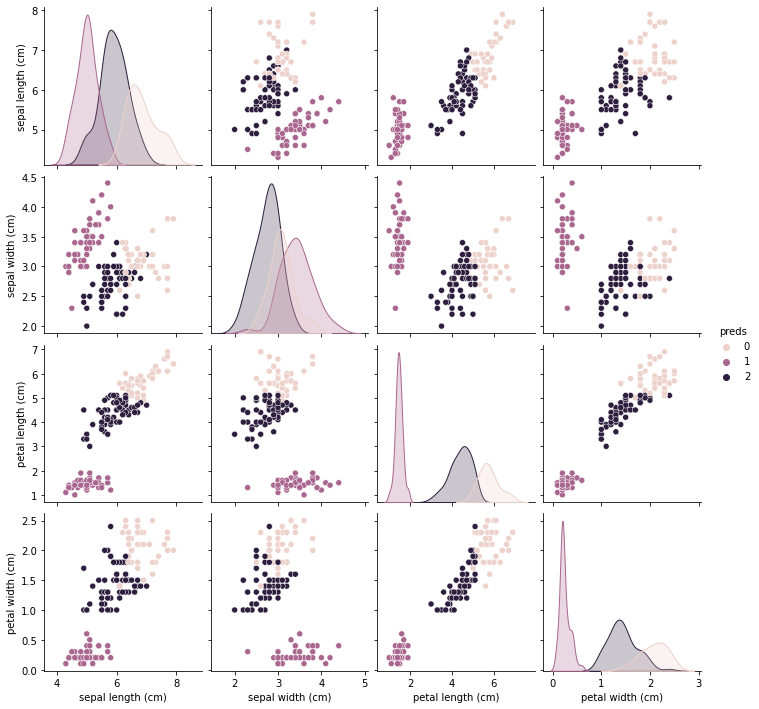

In [96]:
#Pairplot of predictions
sns.pairplot(X.drop('cluster',axis=1), hue='preds')

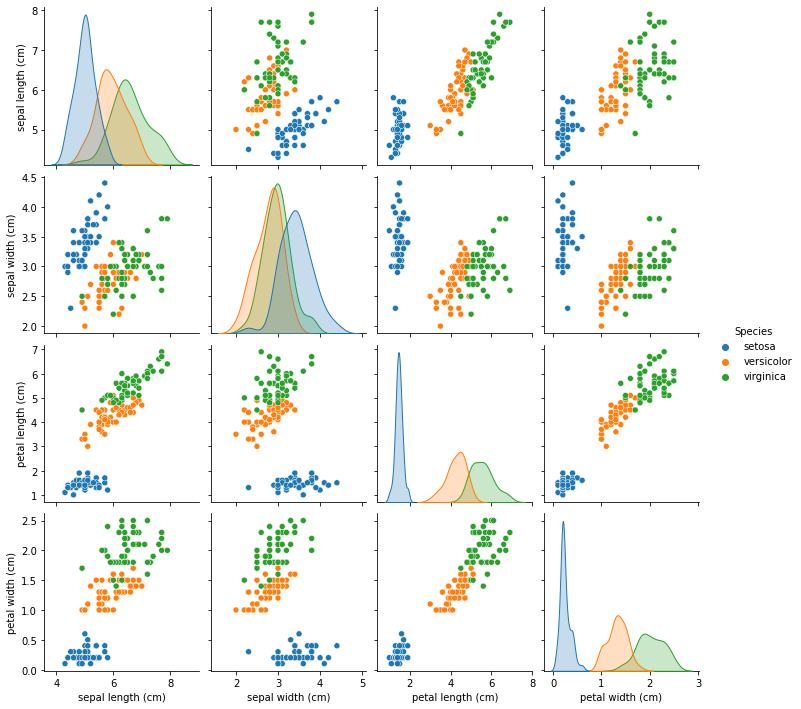

In [90]:
#Pairplot of real clusters
sns.pairplot(df, hue='Species')